# Notebook to develop the model for the project

In [1]:
# All our imports
import torch 
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from random import randint
import PIL
import os

#for all the plots to be inline
%matplotlib inline 


In [2]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, images_folder, transform):
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        filename = self.df.values[index][0]
        labels = np.array([1, 1, 1, 1, 1, 1, 1, 1])
        for x in range(0, 8):
            labels[x] = self.df.values[index][x+1]
        image = PIL.Image.open(os.path.join(self.images_folder, filename))
        if self.transform is not None:
            image = self.transform(image)
        return image, labels

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# device = 'cpu'

In [4]:
'''Data Set manipulation'''
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor()])

root = "C:\\Users\\the_3\\Desktop"

trainDataset = CustomDataset(root + "\\poly-curve-detector\\data\\plotData\\labels\\trainPlots.csv",
                               root + "\\poly-curve-detector\\data\\plotData\\trainPlots", transform)

testDataset = CustomDataset(root + "\\poly-curve-detector\\data\\plotData\\labels\\testPlots.csv",
                               root + "\\poly-curve-detector\\data\\plotData\\testPlots", transform)

#print first label in each dataset
#labels in order [a1,a2,a3,a4,a5,a6,a7,a8]
image, labels = trainDataset[0]
print(labels[0:9])
image, labels = testDataset[0]
print(labels[0:9])

[ 8 -8 -1  0  8  7  7 -5]
[  5 -10  -4   3  -7   7  -9  -7]


In [5]:
train_set = torch.utils.data.DataLoader(trainDataset, shuffle=True, batch_size=128)
test_set = torch.utils.data.DataLoader(testDataset, shuffle=False, batch_size=128)

In [6]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        # more analysis required to determine the specifics of the architecture
       
        self.n_output = 8
        self.n_channel = 1
    
        self.cnn_layers = nn.Sequential(
        #         imageInputLayer([28 28 1])
        #         convolution2dLayer(3,8,'Padding','same')
                nn.Conv2d(1, 8, 3), 
        #         batchNormalizationLayer
                nn.BatchNorm2d(8),
        #         reluLayer
                nn.LeakyReLU(),
        #         averagePooling2dLayer(2,'Stride',2)
                nn.MaxPool2d(2, 2),
        #         convolution2dLayer(3,16,'Padding','same')
                nn.Conv2d(8, 16, 3),
        #         batchNormalizationLayer
                nn.BatchNorm2d(16),
        #         reluLayer
                nn.LeakyReLU(),
        #         averagePooling2dLayer(2,'Stride',2)
                nn.MaxPool2d(2, 2),
        #         convolution2dLayer(3,32,'Padding','same')
                nn.Conv2d(16, 32, 3),
        #         batchNormalizationLayer
                nn.BatchNorm2d(32),
        #         reluLayer
                nn.LeakyReLU(),
        #         convolution2dLayer(3,32,'Padding','same')
                nn.Conv2d(32, 32, 3),
        #         batchNormalizationLayer
                nn.BatchNorm2d(32),
        #         reluLayer
                nn.LeakyReLU(),
        #         Max pooling layer
                nn.MaxPool2d(2, 2)
        )

        self.n_input = 2592 # the output of maxpool 96*96 
        #TODO:actual value might be determined from the computed output of the cnn layers
        # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

        self.fc_layers = nn.Sequential(
#         fullyConnectedLayer(1)
                nn.Linear(self.n_input,  1024),
                nn.LeakyReLU(),
                nn.Linear(1024, 256),
                nn.LeakyReLU(),
                nn.Linear(256, 64),
                nn.LeakyReLU(),
                nn.Linear(64, self.n_output),
                nn.LeakyReLU()
        )


#         regressionLayer
        self.criterion = nn.MSELoss()       
#         dropoutLayer(0.2)
        self.dropout =  nn.Dropout(p=0.2)
        

        
    def forward(self, x):
        #feedword pass through our network
        x = self.cnn_layers(x)
        x = x.view(x.shape[0], -1) #flatten the input tensor
        x = self.fc_layers(x)
        
        return x


    @staticmethod
    def load_checkpoint(new_model, filepath):
        checkpoint = torch.load(filepath)
        # model = Network(
        #         checkpoint['input_size'], 
        #         checkpoint['output_size'],
        #         # checkpoint['cnn_layers'],
        #         # checkpoint['fc_layers']
        # )
        new_model.load_state_dict(checkpoint['state_dict'])
        return new_model
    
    def save(self, dirpath):
        self.checkpoint = {
            'input_size': self.n_input, 
            'output_size': self.n_output,
        #     'cnn_layers': [each. for each in model.cnn_layers],
        #     'fc_layers': [each.out_features for each in model.fc_layers],
            'state_dict': model.state_dict()
        }
        torch.save(self.checkpoint, f'{dirpath}\\model_checkpoint.pth')
    


In [ ]:
    
def validation(model, testloader, criterion):
    accuracy = 0
    test_loss = 0
    for images, labels in testloader:
        if(labels.shape != torch.Size([128, 1, 96, 96])): continue
        # images = images.view(images.shape[0], -1)
        labels = labels.float()
        images, labels = images.to(device), labels.to(device)

        output = model.forward(images)

        # print(f'output={output.shape}')
        # print(f'label={labels.shape}')
        test_loss += criterion(output, labels)

        ## Calculating the accuracy 
        # Model's output is log-softmax, take exponential to get the probabilities
        ps = torch.exp(output)
        # Class with highest probability is our predicted class, compare with true label
        equality = (labels.data == ps.max(1)[1])
        # Accuracy is number of correct predictions divided by all predictions, just take the mean
        accuracy += equality.type_as(torch.FloatTensor()).mean()

    return test_loss, accuracy


def train(model, trainloader, testloader, criterion, optimizer, epochs=5, print_every=40):

    steps = 0
    running_loss = 0
    for e in range(epochs):
        # Model in training mode, dropout is on
        model.train()
        for images, labels in trainloader:
            steps += 1
            # if(labels.shape != torch.Size([128, 1, 96, 96])): continue
            # Flatten images into a 784 long vector
            # images = images.view(images.shape[0], -1)
            labels = labels.float()
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            output = model.forward(images)
            # print(f'output={output.shape}')
            # print(f'label={labels.shape}')
            loss = criterion(output, labels)
            loss.backward() # computes gradient and backpropagation
            optimizer.step() # update of weights and biases happenss
            
            running_loss += loss.item()

            if steps % print_every == 0:
                # Model in inference mode, dropout is off
                model.eval()
                
                # Turn off gradients for validation, will speed up inference
                with torch.no_grad():
                    test_loss, accuracy = validation(model, testloader, criterion)
                
                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                      "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                      "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
                
                running_loss = 0
                
                # Make sure dropout and grads are on for training
                model.train()
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Validation loss')
    plt.legend(frameon=False)

torch.Size([128, 1, 96, 96]) torch.Size([128, 8])
Train Set 0
Image: tensor([[[0.6745, 0.8235, 0.8235,  ..., 0.8235, 0.8235, 0.6745],
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         ...,
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         [0.6745, 0.8235, 0.8235,  ..., 0.8235, 0.8235, 0.6745]]])
Labels: tensor([10,  4, -8, -3,  9, -9,  0, -4], dtype=torch.int32)

torch.Size([1, 96, 96]) torch.Size([8])


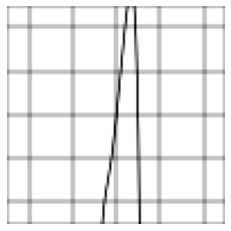

torch.Size([128, 1, 96, 96]) torch.Size([128, 8])
Test Set 0
Image: tensor([[[0.6745, 0.8235, 0.8235,  ..., 0.8235, 0.8235, 0.6745],
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         ...,
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         [0.6745, 0.8235, 0.8235,  ..., 0.8235, 0.8235, 0.6745]]])
Labels: tensor([  5, -10,  -4,   3,  -7,   7,  -9,  -7], dtype=torch.int32)

torch.Size([1, 96, 96]) torch.Size([8])


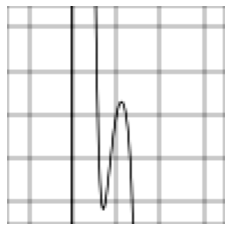

In [8]:
#one way to see batch size
train_batch = next(iter(train_set))
img, lbls = train_batch
print(img.shape, lbls.shape)

#display the first image in train_set
#note: image changes each time run because shuffle is set to true
for images, labels in train_set:
    image = images[0]
    label = labels[0]
    print(f"Train Set 0\nImage: {image}\nLabels: {label}\n")
    print(image.shape, label.shape)
    figure = plt.figure(figsize=(4,4))
    figure.add_subplot()
    plt.axis("off")
    plt.imshow(image.permute(1,2,0), cmap="gray")
    plt.show()
    
    break
    
#test batch size
test_batch = next(iter(test_set))
img, lbls = test_batch
print(img.shape, lbls.shape)

#display the first image in test_set
for images, labels in test_set:
    image = images[0]
    label = labels[0]
    print(f"Test Set 0\nImage: {image}\nLabels: {label}\n")
    print(image.shape, label.shape)
    figure = plt.figure(figsize=(4,4))
    figure.add_subplot()
    plt.axis("off")
    plt.imshow(image.permute(1,2,0), cmap="gray")
    plt.show()
    
    break

In [9]:
# model = Network()
# optimizer = optim.Adam(model.parameters(), lr=0.005)

# output = model.forward(img)
# print(output)
# print(lbls)

In [10]:
# print(output.shape)
# output[0,]

In [11]:
# DONE A: Train model on the data set
    # DONE 1: dataloader be able load (image: tensor, label:string) example of the label tensor([10,-4,-5,3,-2,-3,-2,2]) 
    # DONE 2: fix dimensionality so the net can feedforward a batch of images correctly, move the training to gpu when available
    # DONE 3: make trainloader and testloader dataloaders
# TODO B: Improve model
    # DONE 4: update checkpoint structure to save model and load model
    #TODO 5: use better graphics to display the results (Josias)
    #TODO 6: add a grid to the input like YOLO (hold)
    #TODO 7: Build a list of ideas to improve the nework (Brandon and Josias)
    #DONE 8: Find out if cnn layers learn (Josias)
    #TODO 9: Fix the testloader issue where 8 size expected but found 96 (Brandon)

In [12]:
model = Network()
optimizer = optim.Adam(model.parameters(), lr=0.005)

model.to(device)

train(
    model=model, 
    trainloader=train_set, 
    testloader=test_set, 
    criterion=model.criterion, 
    optimizer=optimizer, 
    epochs=500, 
    print_every=10)


Epoch: 2/500..  Training Loss: 39.188..  Test Loss: 0.000..  Test Accuracy: 0.000
Epoch: 3/500..  Training Loss: 36.745..  Test Loss: 0.000..  Test Accuracy: 0.000
Epoch: 4/500..  Training Loss: 36.547..  Test Loss: 0.000..  Test Accuracy: 0.000
Epoch: 5/500..  Training Loss: 36.542..  Test Loss: 0.000..  Test Accuracy: 0.000
Epoch: 6/500..  Training Loss: 35.214..  Test Loss: 0.000..  Test Accuracy: 0.000
Epoch: 7/500..  Training Loss: 34.691..  Test Loss: 0.000..  Test Accuracy: 0.000
Epoch: 8/500..  Training Loss: 33.236..  Test Loss: 0.000..  Test Accuracy: 0.000
Epoch: 9/500..  Training Loss: 32.206..  Test Loss: 0.000..  Test Accuracy: 0.000
Epoch: 10/500..  Training Loss: 31.469..  Test Loss: 0.000..  Test Accuracy: 0.000
Epoch: 12/500..  Training Loss: 30.529..  Test Loss: 0.000..  Test Accuracy: 0.000
Epoch: 13/500..  Training Loss: 29.477..  Test Loss: 0.000..  Test Accuracy: 0.000
Epoch: 14/500..  Training Loss: 28.796..  Test Loss: 0.000..  Test Accuracy: 0.000
Epoch: 15/50

In [14]:
test_batch = next(iter(test_set))
img, lbls = test_batch
img, lbls = img.to(device), lbls.to(device)
# print(img.shape, lbls.shape)

output = model.forward(img)
print(output)
print(lbls)

tensor([[ 6.8706e+00, -6.1039e+00, -6.7944e+00,  ...,  6.8618e+00,
         -4.7812e+00, -2.9620e+00],
        [-4.6875e+00, -1.0361e+00, -6.6401e+00,  ..., -5.3822e+00,
          5.5313e+00, -5.5687e+00],
        [-9.0155e+00,  7.0952e+00,  5.7094e+00,  ..., -3.3821e+00,
         -1.1521e+00, -7.4920e+00],
        ...,
        [ 1.7944e+00,  3.0226e+00,  9.9051e-01,  ...,  5.9709e+00,
         -3.9717e+00,  1.5932e-01],
        [-9.4934e+00, -4.5737e-03, -3.6645e+00,  ..., -6.7340e+00,
         -5.3202e+00, -8.3084e+00],
        [ 7.1926e+00, -2.2960e+00, -1.8915e+00,  ...,  3.5582e+00,
         -5.6710e+00,  3.3352e+00]], device='cuda:0',
       grad_fn=<LeakyReluBackward0>)
tensor([[  5, -10,  -4,  ...,   7,  -9,  -7],
        [ -5,  -2,  -6,  ...,  -4,   8,  -9],
        [ -9,   9,   0,  ...,  -8,   6, -10],
        ...,
        [  2,   4,   3,  ...,   9, -10,  -1],
        [-10,   0,  -5,  ...,   4,  -8, -10],
        [  8,  -1,  -5,  ...,   8,  -4,   3]], device='cuda:0',
       

In [15]:
model.save('C:\\Users\\the_3\\Desktop\\poly-curve-detector\\Model')

In [16]:
new_model = Network()
Network.load_checkpoint(new_model, "C:\\Users\\the_3\\Desktop\\poly-curve-detector\\Model\\model_checkpoint.pth")

Network(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.01)
    (14): MaxPool2d(kernel_size=2, stride=2

In [17]:
test_batch = next(iter(test_set))
img, lbls = test_batch
# img, lbls = img.to(device), lbls.to(device)
# print(img.shape, lbls.shape)

output = new_model.forward(img)
print(output)
print(lbls)

tensor([[ 6.8706e+00, -6.1039e+00, -6.7944e+00,  ...,  6.8618e+00,
         -4.7812e+00, -2.9620e+00],
        [-4.6875e+00, -1.0361e+00, -6.6401e+00,  ..., -5.3822e+00,
          5.5312e+00, -5.5687e+00],
        [-9.0155e+00,  7.0952e+00,  5.7094e+00,  ..., -3.3821e+00,
         -1.1521e+00, -7.4920e+00],
        ...,
        [ 1.7944e+00,  3.0226e+00,  9.9051e-01,  ...,  5.9709e+00,
         -3.9717e+00,  1.5932e-01],
        [-9.4934e+00, -4.5738e-03, -3.6645e+00,  ..., -6.7340e+00,
         -5.3202e+00, -8.3084e+00],
        [ 7.1926e+00, -2.2960e+00, -1.8915e+00,  ...,  3.5582e+00,
         -5.6710e+00,  3.3352e+00]], grad_fn=<LeakyReluBackward0>)
tensor([[  5, -10,  -4,  ...,   7,  -9,  -7],
        [ -5,  -2,  -6,  ...,  -4,   8,  -9],
        [ -9,   9,   0,  ...,  -8,   6, -10],
        ...,
        [  2,   4,   3,  ...,   9, -10,  -1],
        [-10,   0,  -5,  ...,   4,  -8, -10],
        [  8,  -1,  -5,  ...,   8,  -4,   3]], dtype=torch.int32)
